In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import cache
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import data_manager as dm

# Bag of Words Based Image Retrieval with ORB Features
by [Tristan Cosmo Stérin](http://perso.ens-lyon.fr/tristan.sterin/) / [GitHub](https://github.com/tcosmo/)   
Please refer to the [report](https://github.com/tcosmo/dresscode/blob/master/report.pdf) if you want to know exactly all what this is about and part of.     
In order to judge our Neural Features methods we implement the 'old school' approach to our problem. 
We collect ORB features on each images, learn a dictionary upon it and acheive retrieval with Bag Of Words technique.    
Please find more information on ORB features [here](http://www.dabi.temple.edu/~hbling/Teaching/12S_8543/Presentation/Rublee11ORB.pdf), and more information on BoW techniques [here](https://arxiv.org/abs/1304.5168).    
The ORB method will give us 500 32-dimensional feature vectors per image.

## Getting our Data
Please refer to the repo's readme for a complete description of the data we are using.    
We collect our catalogue item and queries in dictionnaries where the key is the id present in the files names.
As we ignore some of them, id's are not continuous. What we call "class" is the corresponding number when only counting the images we kept.    
We refer to the dresses catalogue with **cat** and to the set of queries with **quer**.

`db/robes/cat/` id ignored: [26, 2, 50, 53, 89, 110, 120, 127, 131, 144, 167, 159, 190, 142]
`db/robes/mod/` id ignored: [26, 2, 50, 53, 89, 110, 120, 127, 131, 144, 167, 159, 190, 142]

The database contains 196 query/item pairs such as:
	db/robes/cat/0_0.jpg
	db/robes/mod/0.jpg

opening db/robes/cat/1_0.jpg
opening db/robes/mod/1.jpg


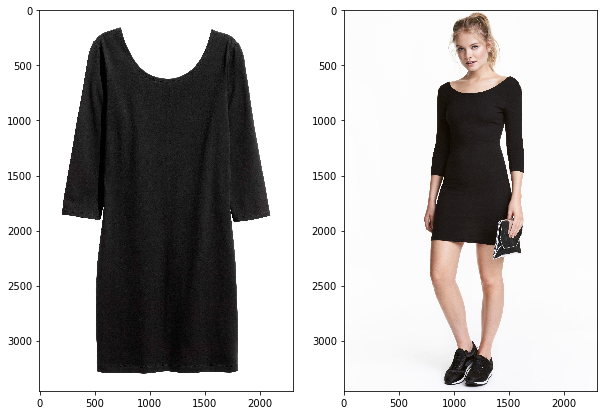

In [13]:
# some data is ill-formated, we dont want it
to_ignore_file = "to_ignore.txt"
db_path = 'db/robes/'

cat_by_id = dm.get_images_by_id(db_path+'cat/',dm.id_getter_cat,dm.id_select_cat,to_ignore_file)
quer_by_id = dm.get_images_by_id(db_path+'mod/',dm.id_getter_quer,dm.id_select_quer,to_ignore_file)

class_of_id, id_of_class = dm.get_id_class_correspondance(cat_by_id)
print("\nThe database contains "+str(len(cat_by_id))+" query/item pairs such as:\n\t"+str(cat_by_id[0])+"\n\t"+str(quer_by_id[0])+"\n")

id_img_ex = 1
img_cat_ex = dm.img_getter(cat_by_id[id_img_ex])
img_quer_ex = dm.img_getter(quer_by_id[id_img_ex])

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img_cat_ex)
plt.subplot(122)
plt.imshow(img_quer_ex)
plt.show()

## Orb Features Collection on the Catalogue
We compute the set of orb features for each image in the catalogue.    
We dump it to a file to avoid calculus when re-using the notebook.  

In [9]:
orb = cv2.ORB_create()

In [4]:
def compute_ORB_features(img_set):
    '''
        Routine to extract orb features for any image set, that is
        a dictionary id -> image_path.
        Returns a dictionary id -> list of features.
    '''
    to_return = {}
    for id_ in img_set:
        gray = dm.img_getter_gray(img_set[id_])
        kp, des = orb.detectAndCompute(gray,None)
        to_return[id_] = des
    return to_return

In [14]:
cat_ORB_per_id = cache.cache("dumps/cat_ORB_per_id.dump",compute_ORB_features,cat_by_id)

opening db/robes/cat/0_0.jpg
opening db/robes/cat/1_0.jpg
opening db/robes/cat/3_0.jpg
opening db/robes/cat/4_0.jpg
...
opening db/robes/cat/209_0.jpg
- Data saved to cache-file: dumps/cat_ORB_per_id.dump


For instance, the ORB feature vector of catalogue image 0 are:

In [16]:
print(cat_ORB_per_id[0])
print(cat_ORB_per_id[0].shape)

[[220  11 200 ..., 245  15 128]
 [240  96 247 ..., 184  70  43]
 [173 201 100 ..., 130 226 224]
 ..., 
 [ 40 102 147 ..., 248  95 168]
 [ 54 104 145 ...,   3   6 166]
 [231  57  37 ..., 101 167 245]]
(500, 32)


### Feature Plotting
We can plot the ORB descriptors in a standard way, they are the green dots on the following image:

opening db/robes/cat/1_0.jpg


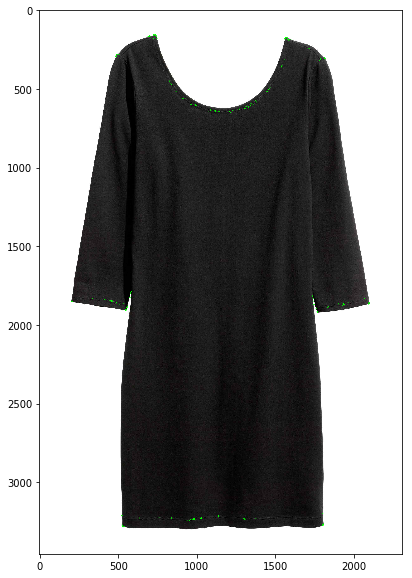

In [15]:
gray = dm.img_getter_gray(cat_by_id[id_img_ex])
kp,_ = orb.detectAndCompute(gray,None) 
img_cat_ex_orb = cv2.drawKeypoints(img_cat_ex, kp, None, color=(0,255,0), flags=0)
plt.figure(figsize=(10,10))
plt.imshow(img_cat_ex_orb)
plt.show()

### Numpy Matrix
We aggregate all the features of all the images in one big matrix.    

In [8]:
all_ORB = cat_ORB_per_id[0]
for id_ in cat_ORB_per_id:
    if id_ == 0:
        continue
    all_ORB = np.r_[all_ORB, cat_ORB_per_id[id_]]
print(all_ORB.shape)

(97012, 32)


## Dictionary Learning
We then aggregate our 97012 feature vectors into 2048 clusters with k-means. 2048 was chosen to mimic the dimension of our Neural Features. Even with 12 processors this process is quite long (12m). We dump the resulting clusters even if they would be different at each run.   
### K-means Aggregation

In [22]:
%%time
kmeans = KMeans(n_clusters=2048,n_jobs=12,verbose=10)
kmeans_result = cache.cache("dumps/cat_ORB_2048_kmeans.dump", kmeans.fit, all_ORB)

center shift 0.000000e+00 within tolerance 5.476140e-01
- Data saved to cache-file: dumps/cat_ORB_2048_kmeans.dump
CPU times: user 2.84 s, sys: 1.03 s, total: 3.87 s
Wall time: 11min 49s


### Dictionary Creation
For each of our image, we compute a visual histogram out of its ORB features. It consists in calculating an histogram of the clusters to which these features belong to.

In [10]:
def get_visual_hist(kmeans,orb_descs):
    '''
        Routine to extract a 'visual histogram', that is 
        a #cluster-dimensional histogram vector, out of a set 
        of orb descriptors.
    '''
    list_cluster = []
    list_cluster = kmeans.predict(orb_descs)
    hist = np.zeros(kmeans.n_clusters)
    for a in list_cluster:
        hist[a] += 1
    return hist.astype(int)

In [13]:
%%time
cat_ORB_dict = {}
for id_ in cat_by_id:
    cat_ORB_dict[id_] = get_visual_hist(kmeans_result,cat_ORB_per_id[id_])

CPU times: user 6.77 s, sys: 30.3 s, total: 37.1 s
Wall time: 2.34 s


For instance here's a visualization of the final feature vector of image 0:

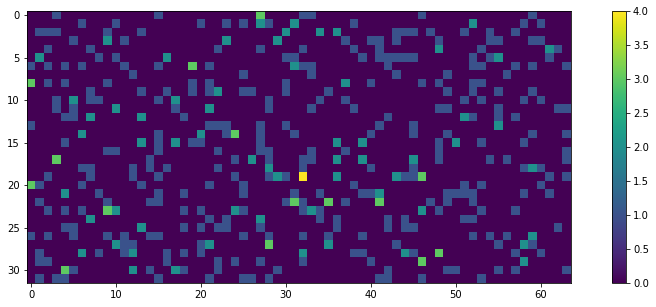

In [14]:
plt.figure(figsize=(15,5))
im = plt.imshow(cat_ORB_dict[0].reshape((2**5,2**6)))
plt.colorbar(im)
plt.show()

### Numpy Matrix
We merge our final dictionary into a np matrix.

In [15]:
cat_ORB_dict_np = [cat_ORB_dict[0]]
for id_ in cat_ORB_dict:
    if id_ == 0:
        continue
    cat_ORB_dict_np = np.r_[cat_ORB_dict_np, [cat_ORB_dict[id_]]]
print(cat_ORB_dict_np.shape)

(196, 2048)


## Retrieval
### Computing ORB Features on Queries

In [52]:
quer_ORB_per_id = cache.cache("dumps/quer_ORB_per_id.dump",compute_ORB_features,quer_by_id)

opening db/robes/mod/0.jpg
opening db/robes/mod/1.jpg
opening db/robes/mod/3.jpg
opening db/robes/mod/4.jpg
...opening db/robes/mod/209.jpg
- Data saved to cache-file: dumps/quer_ORB_per_id.dump


### 10-Nearset Neighbours Model
We construct a 10-NN model over our catalogue dictionary in order to proceed with retrieval and compute 10-accuracy score.

In [17]:
ten_nbrs = NearestNeighbors(n_neighbors=10).fit(cat_ORB_dict_np)

# Results
First we test retrieval for query image 0:

In [18]:
quer_visual_hist = get_visual_hist(kmeans_result,quer_ORB_per_id[0])
distances,indices = ten_nbrs.kneighbors([quer_visual_hist])
print("Top-10 retrieved ids and distances:")
print("\t",indices)
print("\t",distances)
print("\nquery image 0 correct match:",class_of_id[0] in indices[0])

Top-10 retrieved ids and distances:
	 [[ 52  37 108 139   0  43 109 157 185  42]]
	 [[ 32.49615362  32.61901286  33.13608305  33.28663395  33.346664
   33.43650699  33.64520768  33.91164992  34.02939905  34.20526275]]

query image 0 correct match: True


In [21]:
k_accuracy = [1,3,5,10]
success_k = np.zeros(len(k_accuracy))
time_per_query = []
for id_ in quer_ORB_per_id:
    t = time.time()
    quer_visual_hist = get_visual_hist(kmeans_result,quer_ORB_per_id[id_])
    distances,indices = ten_nbrs.kneighbors([quer_visual_hist])
    for i,k in enumerate(k_accuracy):
        success_k[i] += class_of_id[id_] in indices[0][:k]
    time_per_query.append(time.time()-t)
success_k /= len(quer_ORB_per_id)
for i,k in enumerate(k_accuracy):
    print(str(k)+"-accuracy score:",success_k[i])
print("mean time per request:",str(np.array(time_per_query).mean())+"s")

1-accuracy score: 0.0663265306122
3-accuracy score: 0.137755102041
5-accuracy score: 0.204081632653
10-accuracy score: 0.255102040816
mean time per request: 0.0134150689962s


The traditionnal Bag Of Word method achieves a **25% success rate at 10-accuracy**.

## License (MIT)

Copyright (c) 2017 by Tristan Cosmo Stérin

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.